# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import *
#from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 2
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification, workload)
test_data_labels = create_labeled_classes(test_data, classification, workload)
validation_data_labels = create_labeled_classes(validation_data, classification, workload)

## Lambeq optimizer

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
EPOCHS = 10000
initial_number_of_circuits = 340
syms = {}
limit = False
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:initial_number_of_circuits + 1]
current_training_circuits = {}
result_file = workload + "_" + workload_size + "_noisyopt_2_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params)

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
if initial_number_of_circuits > 20 and os.path.exists("points//" + result_file + ".npz"):
    with open("points//" + result_file + ".npz", "rb") as f:
        print("Loading parameters from file " + result_file)
        npzfile = np.load(f)
        init_params_spsa = npzfile['arr_0']
else:
    print("Initializing new parameters")
    init_params_spsa = np.array(rng.random(len(parameters)))
result = None
run = 0

Loading parameters from file execution_time_main_noisyopt_2_2_1_3


Progress:  0.759
Number of training circuits: 339   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 267


Epoch: 200   train/loss: 113.7527   valid/loss: 38.4069   train/acc: 0.3451   valid/acc: 0.3097
Epoch: 400   train/loss: 120.6851   valid/loss: 39.5724   train/acc: 0.2832   valid/acc: 0.292
Epoch: 600   train/loss: 115.0354   valid/loss: 38.6371   train/acc: 0.2655   valid/acc: 0.2832
Epoch: 800   train/loss: 116.8075   valid/loss: 40.925   train/acc: 0.2537   valid/acc: 0.1327
Epoch: 1000   train/loss: 116.6244   valid/loss: 39.4131   train/acc: 0.2891   valid/acc: 0.2301
Epoch: 1200   train/loss: 118.4803   valid/loss: 39.7761   train/acc: 0.2448   valid/acc: 0.2389
Epoch: 1400   train/loss: 116.9075   valid/loss: 38.6723   train/acc: 0.2684   valid/acc: 0.2832
Epoch: 1600   train/loss: 113.2233   valid/loss: 38.3899   train/acc: 0.3127   valid/acc: 0.2301
Epoch: 1800   train/loss: 108.4622   valid/loss: 38.6348   train/acc: 0.3864   valid/acc: 0.3186
Epoch: 2000   train/loss: 109.9618   valid/loss: 40.2047   train/acc: 0.3658   valid/acc: 0.292
Epoch: 2200   train/loss: 108.7968   

Test accuracy: 0.5045045045045045
Progress:  0.761
Number of training circuits: 340   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 267
Progress:  0.763
Number of training circuits: 341   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 267


Epoch: 200   train/loss: 129.3941   valid/loss: 45.1031   train/acc: 0.2669   valid/acc: 0.1593
Epoch: 400   train/loss: 114.0517   valid/loss: 39.0496   train/acc: 0.3021   valid/acc: 0.2832
Epoch: 600   train/loss: 115.9295   valid/loss: 39.0195   train/acc: 0.2962   valid/acc: 0.2389
Epoch: 800   train/loss: 114.2694   valid/loss: 39.2378   train/acc: 0.2639   valid/acc: 0.2655
Epoch: 1000   train/loss: 119.7753   valid/loss: 45.6891   train/acc: 0.2845   valid/acc: 0.2566
Epoch: 1200   train/loss: 119.2122   valid/loss: 40.2174   train/acc: 0.2815   valid/acc: 0.2389
Epoch: 1400   train/loss: 112.1306   valid/loss: 38.79   train/acc: 0.3431   valid/acc: 0.2832
Epoch: 1600   train/loss: 113.6245   valid/loss: 39.5977   train/acc: 0.349   valid/acc: 0.3009
Epoch: 1800   train/loss: 113.0223   valid/loss: 38.9535   train/acc: 0.3314   valid/acc: 0.3097
Epoch: 2000   train/loss: 109.4   valid/loss: 39.8395   train/acc: 0.3812   valid/acc: 0.3009
Epoch: 2200   train/loss: 112.4981   val

Test accuracy: 0.3963963963963964
Progress:  0.766
Number of training circuits: 342   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.768
Number of training circuits: 343   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.77
Number of training circuits: 344   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 116.3377   valid/loss: 39.6767   train/acc: 0.3576   valid/acc: 0.2566
Epoch: 400   train/loss: 116.1243   valid/loss: 38.5926   train/acc: 0.3547   valid/acc: 0.2743
Epoch: 600   train/loss: 113.8285   valid/loss: 38.1366   train/acc: 0.3779   valid/acc: 0.292
Epoch: 800   train/loss: 117.4294   valid/loss: 39.0279   train/acc: 0.2616   valid/acc: 0.3274
Epoch: 1000   train/loss: 113.9399   valid/loss: 38.7864   train/acc: 0.3547   valid/acc: 0.3009
Epoch: 1200   train/loss: 112.5579   valid/loss: 39.2237   train/acc: 0.3285   valid/acc: 0.2301
Epoch: 1400   train/loss: 121.6357   valid/loss: 40.8461   train/acc: 0.2994   valid/acc: 0.2832
Epoch: 1600   train/loss: 108.3715   valid/loss: 39.0307   train/acc: 0.3721   valid/acc: 0.292
Epoch: 1800   train/loss: 103.4496   valid/loss: 37.0755   train/acc: 0.468   valid/acc: 0.3451
Epoch: 2000   train/loss: 111.8011   valid/loss: 38.6819   train/acc: 0.3343   valid/acc: 0.2743
Epoch: 2200   train/loss: 111.6218   

Test accuracy: 0.5135135135135135
Progress:  0.772
Number of training circuits: 345   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.775
Number of training circuits: 346   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.777
Number of training circuits: 347   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 118.1967   valid/loss: 39.5176   train/acc: 0.2536   valid/acc: 0.2212
Epoch: 400   train/loss: 121.7562   valid/loss: 40.3822   train/acc: 0.2968   valid/acc: 0.292
Epoch: 600   train/loss: 116.6689   valid/loss: 37.7503   train/acc: 0.3026   valid/acc: 0.3274
Epoch: 800   train/loss: 117.3065   valid/loss: 38.3181   train/acc: 0.3458   valid/acc: 0.3097
Epoch: 1000   train/loss: 119.2009   valid/loss: 39.8671   train/acc: 0.3112   valid/acc: 0.2743
Epoch: 1200   train/loss: 116.8754   valid/loss: 39.3747   train/acc: 0.317   valid/acc: 0.3097
Epoch: 1400   train/loss: 111.8571   valid/loss: 40.5566   train/acc: 0.3919   valid/acc: 0.2566
Epoch: 1600   train/loss: 111.6934   valid/loss: 39.9465   train/acc: 0.4092   valid/acc: 0.2743
Epoch: 1800   train/loss: 112.7578   valid/loss: 40.2703   train/acc: 0.3516   valid/acc: 0.2566
Epoch: 2000   train/loss: 110.2678   valid/loss: 40.101   train/acc: 0.3718   valid/acc: 0.3009
Epoch: 2200   train/loss: 109.7155   

Test accuracy: 0.40540540540540543
Progress:  0.779
Number of training circuits: 348   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.781
Number of training circuits: 349   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.783
Number of training circuits: 350   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 118.5365   valid/loss: 39.673   train/acc: 0.3486   valid/acc: 0.2566
Epoch: 400   train/loss: 121.3677   valid/loss: 39.751   train/acc: 0.3714   valid/acc: 0.2478
Epoch: 600   train/loss: 116.0023   valid/loss: 38.0403   train/acc: 0.3714   valid/acc: 0.3451
Epoch: 800   train/loss: 116.6779   valid/loss: 38.4775   train/acc: 0.3486   valid/acc: 0.3274
Epoch: 1000   train/loss: 117.2079   valid/loss: 39.3024   train/acc: 0.34   valid/acc: 0.3274
Epoch: 1200   train/loss: 114.9941   valid/loss: 40.1275   train/acc: 0.3714   valid/acc: 0.2832
Epoch: 1400   train/loss: 119.7329   valid/loss: 38.917   train/acc: 0.2971   valid/acc: 0.2212
Epoch: 1600   train/loss: 113.4744   valid/loss: 36.9526   train/acc: 0.2971   valid/acc: 0.3097
Epoch: 1800   train/loss: 109.0346   valid/loss: 37.7406   train/acc: 0.3714   valid/acc: 0.3451
Epoch: 2000   train/loss: 108.9543   valid/loss: 39.5733   train/acc: 0.3657   valid/acc: 0.292
Epoch: 2200   train/loss: 106.976   vali

Test accuracy: 0.3963963963963964
Progress:  0.786
Number of training circuits: 351   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.788
Number of training circuits: 352   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.79
Number of training circuits: 353   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 137.2728   valid/loss: 46.4069   train/acc: 0.238   valid/acc: 0.1947
Epoch: 400   train/loss: 122.4196   valid/loss: 39.1375   train/acc: 0.2691   valid/acc: 0.292
Epoch: 600   train/loss: 123.6572   valid/loss: 39.5594   train/acc: 0.3116   valid/acc: 0.2389
Epoch: 800   train/loss: 118.3381   valid/loss: 39.6392   train/acc: 0.3314   valid/acc: 0.2832
Epoch: 1000   train/loss: 115.9073   valid/loss: 38.9106   train/acc: 0.3314   valid/acc: 0.2655
Epoch: 1200   train/loss: 118.3978   valid/loss: 38.7611   train/acc: 0.2776   valid/acc: 0.2566
Epoch: 1400   train/loss: 125.341   valid/loss: 41.2413   train/acc: 0.3003   valid/acc: 0.2566
Epoch: 1600   train/loss: 113.71   valid/loss: 39.5403   train/acc: 0.3739   valid/acc: 0.3009
Epoch: 1800   train/loss: 113.7486   valid/loss: 40.1794   train/acc: 0.3994   valid/acc: 0.2832
Epoch: 2000   train/loss: 110.924   valid/loss: 38.6601   train/acc: 0.3711   valid/acc: 0.3186
Epoch: 2200   train/loss: 112.8903   val

Test accuracy: 0.5855855855855856
Progress:  0.792
Number of training circuits: 354   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.795
Number of training circuits: 355   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.797
Number of training circuits: 356   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 121.5436   valid/loss: 39.2033   train/acc: 0.2472   valid/acc: 0.2655
Epoch: 400   train/loss: 121.7938   valid/loss: 39.6567   train/acc: 0.2893   valid/acc: 0.2301
Epoch: 600   train/loss: 118.4556   valid/loss: 37.8348   train/acc: 0.3848   valid/acc: 0.3451
Epoch: 800   train/loss: 123.021   valid/loss: 39.0505   train/acc: 0.2584   valid/acc: 0.2743
Epoch: 1000   train/loss: 120.7437   valid/loss: 38.4832   train/acc: 0.2809   valid/acc: 0.2566
Epoch: 1200   train/loss: 119.485   valid/loss: 39.0161   train/acc: 0.2753   valid/acc: 0.2389
Epoch: 1400   train/loss: 120.8972   valid/loss: 38.9962   train/acc: 0.2809   valid/acc: 0.292
Epoch: 1600   train/loss: 119.5397   valid/loss: 38.7817   train/acc: 0.309   valid/acc: 0.292
Epoch: 1800   train/loss: 118.4896   valid/loss: 39.3331   train/acc: 0.3343   valid/acc: 0.2743
Epoch: 2000   train/loss: 121.4841   valid/loss: 40.0546   train/acc: 0.2893   valid/acc: 0.2478
Epoch: 2200   train/loss: 120.0929   va

Test accuracy: 0.5945945945945946
Progress:  0.799
Number of training circuits: 357   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.801
Number of training circuits: 358   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.804
Number of training circuits: 359   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 123.6505   valid/loss: 38.6029   train/acc: 0.2618   valid/acc: 0.2212
Epoch: 400   train/loss: 128.9794   valid/loss: 42.3912   train/acc: 0.2563   valid/acc: 0.2301
Epoch: 600   train/loss: 122.2531   valid/loss: 39.5941   train/acc: 0.2786   valid/acc: 0.2478
Epoch: 800   train/loss: 127.341   valid/loss: 39.8021   train/acc: 0.2173   valid/acc: 0.2035
Epoch: 1000   train/loss: 124.1413   valid/loss: 38.3498   train/acc: 0.2674   valid/acc: 0.2832
Epoch: 1200   train/loss: 124.3882   valid/loss: 38.6515   train/acc: 0.2201   valid/acc: 0.3097
Epoch: 1400   train/loss: 120.39   valid/loss: 39.2214   train/acc: 0.351   valid/acc: 0.2743
Epoch: 1600   train/loss: 116.8408   valid/loss: 37.9359   train/acc: 0.3621   valid/acc: 0.3097
Epoch: 1800   train/loss: 116.8851   valid/loss: 37.5847   train/acc: 0.3649   valid/acc: 0.292
Epoch: 2000   train/loss: 113.4433   valid/loss: 36.4961   train/acc: 0.3983   valid/acc: 0.2832
Epoch: 2200   train/loss: 112.3154   va

Test accuracy: 0.4594594594594595
Progress:  0.806
Number of training circuits: 360   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.808
Number of training circuits: 361   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.81
Number of training circuits: 362   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 125.6703   valid/loss: 38.9877   train/acc: 0.2348   valid/acc: 0.2301
Epoch: 400   train/loss: 123.1632   valid/loss: 38.773   train/acc: 0.3122   valid/acc: 0.3363
Epoch: 600   train/loss: 126.4667   valid/loss: 39.3779   train/acc: 0.2293   valid/acc: 0.2743
Epoch: 800   train/loss: 121.2444   valid/loss: 38.7267   train/acc: 0.3481   valid/acc: 0.2389
Epoch: 1000   train/loss: 123.8283   valid/loss: 38.773   train/acc: 0.2956   valid/acc: 0.3186
Epoch: 1200   train/loss: 123.8505   valid/loss: 39.0418   train/acc: 0.279   valid/acc: 0.3363
Epoch: 1400   train/loss: 124.8618   valid/loss: 38.8202   train/acc: 0.3149   valid/acc: 0.2655
Epoch: 1600   train/loss: 124.427   valid/loss: 38.5075   train/acc: 0.279   valid/acc: 0.2832
Epoch: 1800   train/loss: 121.7063   valid/loss: 39.2456   train/acc: 0.3177   valid/acc: 0.2566
Epoch: 2000   train/loss: 122.5411   valid/loss: 39.1355   train/acc: 0.3177   valid/acc: 0.2478
Epoch: 2200   train/loss: 118.7897   va

Test accuracy: 0.5405405405405406
Progress:  0.812
Number of training circuits: 363   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.815
Number of training circuits: 364   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.817
Number of training circuits: 365   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 124.3235   valid/loss: 39.2538   train/acc: 0.2575   valid/acc: 0.2743
Epoch: 400   train/loss: 122.1165   valid/loss: 37.9862   train/acc: 0.3479   valid/acc: 0.3274
Epoch: 600   train/loss: 128.5494   valid/loss: 40.6013   train/acc: 0.2603   valid/acc: 0.2035
Epoch: 800   train/loss: 123.2269   valid/loss: 39.602   train/acc: 0.3315   valid/acc: 0.1947
Epoch: 1000   train/loss: 126.1543   valid/loss: 39.0098   train/acc: 0.2712   valid/acc: 0.2832
Epoch: 1200   train/loss: 124.4504   valid/loss: 39.6781   train/acc: 0.2959   valid/acc: 0.2035
Epoch: 1400   train/loss: 126.9613   valid/loss: 40.1937   train/acc: 0.1808   valid/acc: 0.2124
Epoch: 1600   train/loss: 125.561   valid/loss: 38.9302   train/acc: 0.2767   valid/acc: 0.3186
Epoch: 1800   train/loss: 120.8467   valid/loss: 39.1597   train/acc: 0.3644   valid/acc: 0.3097
Epoch: 2000   train/loss: 119.661   valid/loss: 38.4081   train/acc: 0.3973   valid/acc: 0.354
Epoch: 2200   train/loss: 116.4795   v

Test accuracy: 0.4774774774774775
Progress:  0.819
Number of training circuits: 366   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.821
Number of training circuits: 367   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.824
Number of training circuits: 368   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 126.8817   valid/loss: 39.3361   train/acc: 0.2989   valid/acc: 0.1947
Epoch: 400   train/loss: 124.083   valid/loss: 38.8155   train/acc: 0.3207   valid/acc: 0.2655
Epoch: 600   train/loss: 121.8862   valid/loss: 39.695   train/acc: 0.3696   valid/acc: 0.2832
Epoch: 800   train/loss: 119.4627   valid/loss: 38.9316   train/acc: 0.3696   valid/acc: 0.2832
Epoch: 1000   train/loss: 118.2959   valid/loss: 37.9693   train/acc: 0.4022   valid/acc: 0.2832
Epoch: 1200   train/loss: 125.7993   valid/loss: 38.9415   train/acc: 0.2935   valid/acc: 0.3186
Epoch: 1400   train/loss: 124.4486   valid/loss: 39.9915   train/acc: 0.3397   valid/acc: 0.2655
Epoch: 1600   train/loss: 119.4659   valid/loss: 39.6764   train/acc: 0.3424   valid/acc: 0.2655
Epoch: 1800   train/loss: 124.1955   valid/loss: 39.1052   train/acc: 0.2745   valid/acc: 0.3009
Epoch: 2000   train/loss: 123.3489   valid/loss: 39.4066   train/acc: 0.3478   valid/acc: 0.2832
Epoch: 2200   train/loss: 120.8784  

Test accuracy: 0.4774774774774775
Progress:  0.826
Number of training circuits: 369   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.828
Number of training circuits: 370   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.83
Number of training circuits: 371   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 125.8862   valid/loss: 38.9368   train/acc: 0.3827   valid/acc: 0.2478
Epoch: 400   train/loss: 136.5864   valid/loss: 42.1391   train/acc: 0.2695   valid/acc: 0.3097
Epoch: 600   train/loss: 126.797   valid/loss: 39.264   train/acc: 0.2561   valid/acc: 0.2566
Epoch: 800   train/loss: 134.2569   valid/loss: 42.6875   train/acc: 0.2857   valid/acc: 0.3009
Epoch: 1000   train/loss: 128.3232   valid/loss: 39.4815   train/acc: 0.2183   valid/acc: 0.2124
Epoch: 1200   train/loss: 127.4019   valid/loss: 39.2964   train/acc: 0.2561   valid/acc: 0.177
Epoch: 1400   train/loss: 126.4035   valid/loss: 39.677   train/acc: 0.2453   valid/acc: 0.2478
Epoch: 1600   train/loss: 123.1445   valid/loss: 40.0696   train/acc: 0.3073   valid/acc: 0.2301
Epoch: 1800   train/loss: 123.1656   valid/loss: 39.4335   train/acc: 0.2965   valid/acc: 0.2301
Epoch: 2000   train/loss: 125.17   valid/loss: 39.3101   train/acc: 0.2965   valid/acc: 0.2478
Epoch: 2200   train/loss: 121.2766   val

Test accuracy: 0.4594594594594595
Progress:  0.833
Number of training circuits: 372   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.835
Number of training circuits: 373   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.837
Number of training circuits: 374   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 131.5383   valid/loss: 38.838   train/acc: 0.2567   valid/acc: 0.3274
Epoch: 400   train/loss: 133.1508   valid/loss: 42.3973   train/acc: 0.2941   valid/acc: 0.3097
Epoch: 600   train/loss: 125.162   valid/loss: 38.4253   train/acc: 0.3342   valid/acc: 0.3097
Epoch: 800   train/loss: 124.8345   valid/loss: 39.435   train/acc: 0.3503   valid/acc: 0.2478
Epoch: 1000   train/loss: 124.4695   valid/loss: 39.1647   train/acc: 0.3235   valid/acc: 0.2832
Epoch: 1200   train/loss: 123.9116   valid/loss: 38.7113   train/acc: 0.3048   valid/acc: 0.3097
Epoch: 1400   train/loss: 122.0724   valid/loss: 39.191   train/acc: 0.3209   valid/acc: 0.3717
Epoch: 1600   train/loss: 119.7478   valid/loss: 38.0328   train/acc: 0.4144   valid/acc: 0.3274
Epoch: 1800   train/loss: 123.7292   valid/loss: 38.8836   train/acc: 0.3797   valid/acc: 0.3097
Epoch: 2000   train/loss: 116.4969   valid/loss: 38.0063   train/acc: 0.4439   valid/acc: 0.3274
Epoch: 2200   train/loss: 113.1814   v

Test accuracy: 0.5315315315315315
Progress:  0.839
Number of training circuits: 375   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.842
Number of training circuits: 376   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.844
Number of training circuits: 377   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 130.3765   valid/loss: 39.1781   train/acc: 0.2467   valid/acc: 0.2832
Epoch: 400   train/loss: 125.4437   valid/loss: 39.0562   train/acc: 0.3634   valid/acc: 0.2743
Epoch: 600   train/loss: 122.5473   valid/loss: 39.01   train/acc: 0.366   valid/acc: 0.2655
Epoch: 800   train/loss: 123.0836   valid/loss: 38.3015   train/acc: 0.3448   valid/acc: 0.2743
Epoch: 1000   train/loss: 125.5732   valid/loss: 39.0675   train/acc: 0.3422   valid/acc: 0.2743
Epoch: 1200   train/loss: 126.41   valid/loss: 40.4025   train/acc: 0.3873   valid/acc: 0.2655
Epoch: 1400   train/loss: 125.4294   valid/loss: 39.3069   train/acc: 0.321   valid/acc: 0.2478
Epoch: 1600   train/loss: 133.8747   valid/loss: 39.9867   train/acc: 0.2679   valid/acc: 0.2566
Epoch: 1800   train/loss: 124.3127   valid/loss: 38.4781   train/acc: 0.3554   valid/acc: 0.3009
Epoch: 2000   train/loss: 119.4457   valid/loss: 38.4081   train/acc: 0.382   valid/acc: 0.3097
Epoch: 2200   train/loss: 118.782   valid

Test accuracy: 0.42342342342342343
Progress:  0.846
Number of training circuits: 378   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.848
Number of training circuits: 379   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.85
Number of training circuits: 380   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 130.015   valid/loss: 39.2106   train/acc: 0.2763   valid/acc: 0.2212
Epoch: 400   train/loss: 124.7702   valid/loss: 40.9068   train/acc: 0.2868   valid/acc: 0.2832
Epoch: 600   train/loss: 126.7794   valid/loss: 38.3743   train/acc: 0.3395   valid/acc: 0.3274
Epoch: 800   train/loss: 124.5988   valid/loss: 38.4159   train/acc: 0.3711   valid/acc: 0.3097
Epoch: 1000   train/loss: 131.6792   valid/loss: 38.6211   train/acc: 0.2737   valid/acc: 0.3097
Epoch: 1200   train/loss: 133.4449   valid/loss: 39.2758   train/acc: 0.2789   valid/acc: 0.292
Epoch: 1400   train/loss: 134.0928   valid/loss: 39.2747   train/acc: 0.2658   valid/acc: 0.2389
Epoch: 1600   train/loss: 132.208   valid/loss: 39.4154   train/acc: 0.3053   valid/acc: 0.2389
Epoch: 1800   train/loss: 123.709   valid/loss: 40.6294   train/acc: 0.4105   valid/acc: 0.3097
Epoch: 2000   train/loss: 120.9877   valid/loss: 41.4161   train/acc: 0.4237   valid/acc: 0.3186
Epoch: 2200   train/loss: 121.4924   v

Test accuracy: 0.4864864864864865
Progress:  0.853
Number of training circuits: 381   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.855
Number of training circuits: 382   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.857
Number of training circuits: 383   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 133.1297   valid/loss: 39.2178   train/acc: 0.2272   valid/acc: 0.3274
Epoch: 400   train/loss: 134.0332   valid/loss: 40.3262   train/acc: 0.2768   valid/acc: 0.2035
Epoch: 600   train/loss: 138.8221   valid/loss: 41.2659   train/acc: 0.2715   valid/acc: 0.2743
Epoch: 800   train/loss: 129.7744   valid/loss: 38.1853   train/acc: 0.3185   valid/acc: 0.3982
Epoch: 1000   train/loss: 134.0631   valid/loss: 41.1619   train/acc: 0.2768   valid/acc: 0.3363
Epoch: 1200   train/loss: 127.0998   valid/loss: 39.5342   train/acc: 0.2585   valid/acc: 0.2478
Epoch: 1400   train/loss: 124.7833   valid/loss: 38.8868   train/acc: 0.4099   valid/acc: 0.3186
Epoch: 1600   train/loss: 122.9853   valid/loss: 41.4502   train/acc: 0.3368   valid/acc: 0.2301
Epoch: 1800   train/loss: 121.034   valid/loss: 41.0229   train/acc: 0.3603   valid/acc: 0.2389
Epoch: 2000   train/loss: 123.8349   valid/loss: 41.2765   train/acc: 0.3107   valid/acc: 0.2566
Epoch: 2200   train/loss: 124.6397 

Test accuracy: 0.5225225225225225
Progress:  0.859
Number of training circuits: 384   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.862
Number of training circuits: 385   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.864
Number of training circuits: 386   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 146.2355   valid/loss: 41.3499   train/acc: 0.2409   valid/acc: 0.2035
Epoch: 400   train/loss: 129.1077   valid/loss: 38.979   train/acc: 0.3472   valid/acc: 0.292
Epoch: 600   train/loss: 132.3101   valid/loss: 39.2231   train/acc: 0.3161   valid/acc: 0.2743
Epoch: 800   train/loss: 134.59   valid/loss: 39.7414   train/acc: 0.3264   valid/acc: 0.2832
Epoch: 1000   train/loss: 132.4939   valid/loss: 40.3962   train/acc: 0.2824   valid/acc: 0.2655
Epoch: 1200   train/loss: 130.908   valid/loss: 38.6201   train/acc: 0.3005   valid/acc: 0.2389
Epoch: 1400   train/loss: 127.7844   valid/loss: 37.7101   train/acc: 0.3342   valid/acc: 0.2655
Epoch: 1600   train/loss: 134.5381   valid/loss: 40.3288   train/acc: 0.2927   valid/acc: 0.3451
Epoch: 1800   train/loss: 134.0936   valid/loss: 43.6542   train/acc: 0.3394   valid/acc: 0.2655
Epoch: 2000   train/loss: 126.4023   valid/loss: 39.2693   train/acc: 0.3212   valid/acc: 0.292
Epoch: 2200   train/loss: 119.4597   val

Test accuracy: 0.5315315315315315
Progress:  0.866
Number of training circuits: 387   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.868
Number of training circuits: 388   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.871
Number of training circuits: 389   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 132.9389   valid/loss: 40.2952   train/acc: 0.2879   valid/acc: 0.2035
Epoch: 400   train/loss: 132.4985   valid/loss: 39.33   train/acc: 0.3085   valid/acc: 0.2832
Epoch: 600   train/loss: 133.0908   valid/loss: 39.8553   train/acc: 0.3265   valid/acc: 0.2832
Epoch: 800   train/loss: 131.7875   valid/loss: 38.9709   train/acc: 0.3393   valid/acc: 0.3009
Epoch: 1000   train/loss: 133.9581   valid/loss: 38.658   train/acc: 0.2339   valid/acc: 0.2832
Epoch: 1200   train/loss: 133.0397   valid/loss: 39.5505   train/acc: 0.329   valid/acc: 0.3097
Epoch: 1400   train/loss: 132.6925   valid/loss: 37.0046   train/acc: 0.2879   valid/acc: 0.3451
Epoch: 1600   train/loss: 130.7117   valid/loss: 41.3906   train/acc: 0.3419   valid/acc: 0.2212
Epoch: 1800   train/loss: 125.6348   valid/loss: 39.9316   train/acc: 0.3573   valid/acc: 0.3186
Epoch: 2000   train/loss: 128.6875   valid/loss: 39.4761   train/acc: 0.2931   valid/acc: 0.2655
Epoch: 2200   train/loss: 121.1395   v

Test accuracy: 0.4864864864864865
Progress:  0.873
Number of training circuits: 390   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.875
Number of training circuits: 391   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.877
Number of training circuits: 392   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 135.3216   valid/loss: 39.3876   train/acc: 0.2908   valid/acc: 0.3186
Epoch: 400   train/loss: 131.7203   valid/loss: 37.9615   train/acc: 0.3061   valid/acc: 0.2655
Epoch: 600   train/loss: 130.3152   valid/loss: 39.4484   train/acc: 0.3316   valid/acc: 0.2655
Epoch: 800   train/loss: 128.6964   valid/loss: 39.4571   train/acc: 0.3673   valid/acc: 0.1947
Epoch: 1000   train/loss: 128.1045   valid/loss: 38.4788   train/acc: 0.3265   valid/acc: 0.3009
Epoch: 1200   train/loss: 133.9082   valid/loss: 38.6077   train/acc: 0.2959   valid/acc: 0.3274
Epoch: 1400   train/loss: 123.7706   valid/loss: 38.6263   train/acc: 0.3954   valid/acc: 0.3009
Epoch: 1600   train/loss: 132.8479   valid/loss: 39.1785   train/acc: 0.3163   valid/acc: 0.2743
Epoch: 1800   train/loss: 130.267   valid/loss: 38.4867   train/acc: 0.3597   valid/acc: 0.3274
Epoch: 2000   train/loss: 128.6761   valid/loss: 39.4851   train/acc: 0.3546   valid/acc: 0.3274
Epoch: 2200   train/loss: 124.4717 

Test accuracy: 0.44144144144144143
Progress:  0.879
Number of training circuits: 393   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.882
Number of training circuits: 394   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.884
Number of training circuits: 395   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 137.0347   valid/loss: 39.4776   train/acc: 0.2532   valid/acc: 0.2389
Epoch: 400   train/loss: 141.8158   valid/loss: 41.1275   train/acc: 0.2253   valid/acc: 0.1858
Epoch: 600   train/loss: 136.5295   valid/loss: 39.2538   train/acc: 0.2861   valid/acc: 0.2301
Epoch: 800   train/loss: 128.0112   valid/loss: 38.2053   train/acc: 0.3519   valid/acc: 0.2832
Epoch: 1000   train/loss: 132.9075   valid/loss: 40.6783   train/acc: 0.3291   valid/acc: 0.3274
Epoch: 1200   train/loss: 130.7928   valid/loss: 38.2053   train/acc: 0.3266   valid/acc: 0.3363
Epoch: 1400   train/loss: 130.2513   valid/loss: 38.3796   train/acc: 0.3975   valid/acc: 0.3805
Epoch: 1600   train/loss: 125.3646   valid/loss: 39.3758   train/acc: 0.4076   valid/acc: 0.3717
Epoch: 1800   train/loss: 121.884   valid/loss: 38.6354   train/acc: 0.4557   valid/acc: 0.3451
Epoch: 2000   train/loss: 124.8891   valid/loss: 39.4971   train/acc: 0.3772   valid/acc: 0.3009
Epoch: 2200   train/loss: 121.3481 

Test accuracy: 0.43243243243243246
Progress:  0.886
Number of training circuits: 396   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.888
Number of training circuits: 397   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279
Progress:  0.891
Number of training circuits: 398   Number of validation circuits: 113   Number of test circuits: 111   Number of parameters in model: 279


Epoch: 200   train/loss: 146.7698   valid/loss: 39.0745   train/acc: 0.2638   valid/acc: 0.2566
Epoch: 400   train/loss: 145.7091   valid/loss: 42.5844   train/acc: 0.2688   valid/acc: 0.2301
Epoch: 600   train/loss: 135.8315   valid/loss: 39.3885   train/acc: 0.3191   valid/acc: 0.292
Epoch: 800   train/loss: 136.4239   valid/loss: 39.044   train/acc: 0.3392   valid/acc: 0.3363
Epoch: 1000   train/loss: 136.6466   valid/loss: 38.9084   train/acc: 0.2889   valid/acc: 0.2832
Epoch: 1200   train/loss: 153.1727   valid/loss: 42.5574   train/acc: 0.201   valid/acc: 0.2389
Epoch: 1400   train/loss: 138.8173   valid/loss: 39.5729   train/acc: 0.299   valid/acc: 0.2743
Epoch: 1600   train/loss: 138.4718   valid/loss: 44.4177   train/acc: 0.299   valid/acc: 0.1681
Epoch: 1800   train/loss: 130.8964   valid/loss: 39.7192   train/acc: 0.3141   valid/acc: 0.292
Epoch: 2000   train/loss: 119.843   valid/loss: 40.1658   train/acc: 0.5   valid/acc: 0.3274
Epoch: 2200   train/loss: 130.0293   valid/l

Test accuracy: 0.4594594594594595
Progress:  0.893
Number of training circuits: 399   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.895
Number of training circuits: 400   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.897
Number of training circuits: 401   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 155.4245   valid/loss: 41.9032   train/acc: 0.192   valid/acc: 0.2124
Epoch: 400   train/loss: 135.8572   valid/loss: 39.2565   train/acc: 0.2843   valid/acc: 0.2655
Epoch: 600   train/loss: 137.0276   valid/loss: 38.9503   train/acc: 0.2469   valid/acc: 0.2035
Epoch: 800   train/loss: 150.3125   valid/loss: 41.4949   train/acc: 0.2918   valid/acc: 0.3009
Epoch: 1000   train/loss: 135.2484   valid/loss: 38.0144   train/acc: 0.2618   valid/acc: 0.2655
Epoch: 1200   train/loss: 137.1257   valid/loss: 37.6792   train/acc: 0.2943   valid/acc: 0.3363
Epoch: 1400   train/loss: 131.9116   valid/loss: 39.2948   train/acc: 0.389   valid/acc: 0.3363
Epoch: 1600   train/loss: 131.5031   valid/loss: 39.3301   train/acc: 0.3466   valid/acc: 0.2743
Epoch: 1800   train/loss: 127.1913   valid/loss: 37.8045   train/acc: 0.4613   valid/acc: 0.3982
Epoch: 2000   train/loss: 128.2059   valid/loss: 39.9157   train/acc: 0.3791   valid/acc: 0.3717
Epoch: 2200   train/loss: 123.6922  

Test accuracy: 0.42857142857142855
Progress:  0.9
Number of training circuits: 402   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.902
Number of training circuits: 403   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.904
Number of training circuits: 404   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 138.2066   valid/loss: 38.8874   train/acc: 0.203   valid/acc: 0.2655
Epoch: 400   train/loss: 139.1172   valid/loss: 38.6595   train/acc: 0.2673   valid/acc: 0.3274
Epoch: 600   train/loss: 137.3419   valid/loss: 38.8762   train/acc: 0.2624   valid/acc: 0.292
Epoch: 800   train/loss: 135.7222   valid/loss: 38.5742   train/acc: 0.3688   valid/acc: 0.3451
Epoch: 1000   train/loss: 128.2025   valid/loss: 40.2268   train/acc: 0.3416   valid/acc: 0.2389
Epoch: 1200   train/loss: 146.1235   valid/loss: 40.9092   train/acc: 0.2946   valid/acc: 0.292
Epoch: 1400   train/loss: 135.9109   valid/loss: 38.2596   train/acc: 0.3366   valid/acc: 0.3097
Epoch: 1600   train/loss: 129.7162   valid/loss: 37.6313   train/acc: 0.3713   valid/acc: 0.2832
Epoch: 1800   train/loss: 134.1226   valid/loss: 38.4633   train/acc: 0.3589   valid/acc: 0.3451
Epoch: 2000   train/loss: 147.7234   valid/loss: 40.8729   train/acc: 0.255   valid/acc: 0.2655
Epoch: 2200   train/loss: 128.6928   v

Test accuracy: 0.4017857142857143
Progress:  0.906
Number of training circuits: 405   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.908
Number of training circuits: 406   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.911
Number of training circuits: 407   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 139.7287   valid/loss: 38.5334   train/acc: 0.3145   valid/acc: 0.3805
Epoch: 400   train/loss: 135.8049   valid/loss: 38.0121   train/acc: 0.3661   valid/acc: 0.3363
Epoch: 600   train/loss: 141.2524   valid/loss: 39.032   train/acc: 0.2948   valid/acc: 0.2389
Epoch: 800   train/loss: 140.1074   valid/loss: 39.3907   train/acc: 0.3292   valid/acc: 0.2832
Epoch: 1000   train/loss: 134.7979   valid/loss: 39.0986   train/acc: 0.3194   valid/acc: 0.292
Epoch: 1200   train/loss: 135.4512   valid/loss: 46.6804   train/acc: 0.3219   valid/acc: 0.2301
Epoch: 1400   train/loss: 131.8781   valid/loss: 39.4333   train/acc: 0.3563   valid/acc: 0.3009
Epoch: 1600   train/loss: 137.6511   valid/loss: 42.5603   train/acc: 0.2383   valid/acc: 0.2655
Epoch: 1800   train/loss: 136.4199   valid/loss: 41.139   train/acc: 0.3022   valid/acc: 0.2743
Epoch: 2000   train/loss: 132.2532   valid/loss: 42.5634   train/acc: 0.4054   valid/acc: 0.2832
Epoch: 2200   train/loss: 127.7478   

Test accuracy: 0.44642857142857145
Progress:  0.913
Number of training circuits: 408   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.915
Number of training circuits: 409   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.917
Number of training circuits: 410   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 144.441   valid/loss: 40.6616   train/acc: 0.2951   valid/acc: 0.292
Epoch: 400   train/loss: 141.0299   valid/loss: 38.7264   train/acc: 0.2732   valid/acc: 0.2389
Epoch: 600   train/loss: 141.6604   valid/loss: 39.3625   train/acc: 0.2415   valid/acc: 0.2389
Epoch: 800   train/loss: 141.2377   valid/loss: 38.8975   train/acc: 0.2561   valid/acc: 0.2655
Epoch: 1000   train/loss: 132.92   valid/loss: 37.7548   train/acc: 0.3732   valid/acc: 0.292
Epoch: 1200   train/loss: 134.6139   valid/loss: 38.8192   train/acc: 0.3585   valid/acc: 0.2212
Epoch: 1400   train/loss: 137.7259   valid/loss: 38.1005   train/acc: 0.3171   valid/acc: 0.3009
Epoch: 1600   train/loss: 134.3475   valid/loss: 38.715   train/acc: 0.3171   valid/acc: 0.2743
Epoch: 1800   train/loss: 139.4668   valid/loss: 39.5227   train/acc: 0.4073   valid/acc: 0.3805
Epoch: 2000   train/loss: 129.3944   valid/loss: 37.1982   train/acc: 0.3732   valid/acc: 0.3363
Epoch: 2200   train/loss: 136.6477   val

Test accuracy: 0.41964285714285715
Progress:  0.92
Number of training circuits: 411   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.922
Number of training circuits: 412   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.924
Number of training circuits: 413   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 142.7543   valid/loss: 39.7276   train/acc: 0.2833   valid/acc: 0.2566
Epoch: 400   train/loss: 137.6958   valid/loss: 38.7597   train/acc: 0.3269   valid/acc: 0.292
Epoch: 600   train/loss: 142.9104   valid/loss: 39.5954   train/acc: 0.2736   valid/acc: 0.2035
Epoch: 800   train/loss: 139.6586   valid/loss: 38.5731   train/acc: 0.3341   valid/acc: 0.2743
Epoch: 1000   train/loss: 136.7355   valid/loss: 38.1552   train/acc: 0.3099   valid/acc: 0.354
Epoch: 1200   train/loss: 131.9216   valid/loss: 37.2367   train/acc: 0.3874   valid/acc: 0.3894
Epoch: 1400   train/loss: 135.062   valid/loss: 38.6526   train/acc: 0.3801   valid/acc: 0.2832
Epoch: 1600   train/loss: 142.889   valid/loss: 40.1163   train/acc: 0.2809   valid/acc: 0.2212
Epoch: 1800   train/loss: 129.1504   valid/loss: 39.1034   train/acc: 0.4165   valid/acc: 0.3186
Epoch: 2000   train/loss: 137.4999   valid/loss: 42.9016   train/acc: 0.3584   valid/acc: 0.2301
Epoch: 2200   train/loss: 121.2663   v

Test accuracy: 0.44642857142857145
Progress:  0.926
Number of training circuits: 414   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.929
Number of training circuits: 415   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.931
Number of training circuits: 416   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 140.6467   valid/loss: 38.7969   train/acc: 0.3101   valid/acc: 0.3274
Epoch: 400   train/loss: 158.3893   valid/loss: 44.1721   train/acc: 0.2212   valid/acc: 0.2566
Epoch: 600   train/loss: 139.203   valid/loss: 38.9528   train/acc: 0.2933   valid/acc: 0.292
Epoch: 800   train/loss: 154.6307   valid/loss: 42.7281   train/acc: 0.238   valid/acc: 0.2301
Epoch: 1000   train/loss: 140.9761   valid/loss: 39.2477   train/acc: 0.2644   valid/acc: 0.2478
Epoch: 1200   train/loss: 141.4895   valid/loss: 39.3974   train/acc: 0.2957   valid/acc: 0.2301
Epoch: 1400   train/loss: 144.9634   valid/loss: 39.0522   train/acc: 0.2188   valid/acc: 0.2566
Epoch: 1600   train/loss: 140.5903   valid/loss: 38.9391   train/acc: 0.3029   valid/acc: 0.2212
Epoch: 1800   train/loss: 135.4587   valid/loss: 37.9545   train/acc: 0.3293   valid/acc: 0.2478
Epoch: 2000   train/loss: 133.9642   valid/loss: 38.9096   train/acc: 0.3365   valid/acc: 0.292
Epoch: 2200   train/loss: 139.8387   v

Test accuracy: 0.4375
Progress:  0.933
Number of training circuits: 417   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.935
Number of training circuits: 418   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.938
Number of training circuits: 419   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 147.8643   valid/loss: 40.324   train/acc: 0.2578   valid/acc: 0.2478
Epoch: 400   train/loss: 148.4804   valid/loss: 40.7835   train/acc: 0.2816   valid/acc: 0.1858
Epoch: 600   train/loss: 137.1187   valid/loss: 38.418   train/acc: 0.3508   valid/acc: 0.2655
Epoch: 800   train/loss: 141.9152   valid/loss: 38.9163   train/acc: 0.3532   valid/acc: 0.3717
Epoch: 1000   train/loss: 140.1861   valid/loss: 39.2082   train/acc: 0.3294   valid/acc: 0.292
Epoch: 1200   train/loss: 134.7616   valid/loss: 38.3436   train/acc: 0.358   valid/acc: 0.3363
Epoch: 1400   train/loss: 136.3816   valid/loss: 38.0746   train/acc: 0.3723   valid/acc: 0.3186
Epoch: 1600   train/loss: 137.7549   valid/loss: 40.9477   train/acc: 0.3532   valid/acc: 0.3274
Epoch: 1800   train/loss: 147.1461   valid/loss: 40.3266   train/acc: 0.2649   valid/acc: 0.2389
Epoch: 2000   train/loss: 143.9614   valid/loss: 39.1714   train/acc: 0.2959   valid/acc: 0.292
Epoch: 2200   train/loss: 137.8172   va

Test accuracy: 0.41964285714285715
Progress:  0.94
Number of training circuits: 420   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.942
Number of training circuits: 421   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.944
Number of training circuits: 422   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 144.729   valid/loss: 39.2187   train/acc: 0.2583   valid/acc: 0.2389
Epoch: 400   train/loss: 142.7412   valid/loss: 38.8308   train/acc: 0.3365   valid/acc: 0.3274
Epoch: 600   train/loss: 145.9229   valid/loss: 39.3916   train/acc: 0.2962   valid/acc: 0.2478
Epoch: 800   train/loss: 144.0255   valid/loss: 38.9219   train/acc: 0.2844   valid/acc: 0.2212
Epoch: 1000   train/loss: 143.6432   valid/loss: 38.1454   train/acc: 0.3057   valid/acc: 0.3717
Epoch: 1200   train/loss: 136.7206   valid/loss: 38.1005   train/acc: 0.3957   valid/acc: 0.3363
Epoch: 1400   train/loss: 145.2909   valid/loss: 39.3609   train/acc: 0.327   valid/acc: 0.2832
Epoch: 1600   train/loss: 149.7665   valid/loss: 40.0007   train/acc: 0.3602   valid/acc: 0.3009
Epoch: 1800   train/loss: 137.4037   valid/loss: 38.7761   train/acc: 0.4028   valid/acc: 0.2832
Epoch: 2000   train/loss: 139.3614   valid/loss: 39.3184   train/acc: 0.3223   valid/acc: 0.2743
Epoch: 2200   train/loss: 139.6845  

Test accuracy: 0.45535714285714285
Progress:  0.946
Number of training circuits: 423   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.949
Number of training circuits: 424   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.951
Number of training circuits: 425   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 146.1528   valid/loss: 38.4229   train/acc: 0.2235   valid/acc: 0.2566
Epoch: 400   train/loss: 151.2876   valid/loss: 39.655   train/acc: 0.2706   valid/acc: 0.3009
Epoch: 600   train/loss: 141.4297   valid/loss: 38.9691   train/acc: 0.3365   valid/acc: 0.292
Epoch: 800   train/loss: 144.2421   valid/loss: 38.5845   train/acc: 0.2376   valid/acc: 0.2389
Epoch: 1000   train/loss: 142.0714   valid/loss: 39.3738   train/acc: 0.3318   valid/acc: 0.2655
Epoch: 1200   train/loss: 141.613   valid/loss: 38.1255   train/acc: 0.3153   valid/acc: 0.292
Epoch: 1400   train/loss: 138.5087   valid/loss: 38.3755   train/acc: 0.3482   valid/acc: 0.3097
Epoch: 1600   train/loss: 137.9694   valid/loss: 38.9446   train/acc: 0.3694   valid/acc: 0.3274
Epoch: 1800   train/loss: 139.007   valid/loss: 37.4303   train/acc: 0.3835   valid/acc: 0.2832
Epoch: 2000   train/loss: 139.5664   valid/loss: 37.571   train/acc: 0.3365   valid/acc: 0.3805
Epoch: 2200   train/loss: 136.259   vali

Test accuracy: 0.4017857142857143
Progress:  0.953
Number of training circuits: 426   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.955
Number of training circuits: 427   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.958
Number of training circuits: 428   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 162.6644   valid/loss: 45.4817   train/acc: 0.2173   valid/acc: 0.2478
Epoch: 400   train/loss: 145.5045   valid/loss: 38.8901   train/acc: 0.285   valid/acc: 0.2212
Epoch: 600   train/loss: 142.3602   valid/loss: 38.5535   train/acc: 0.285   valid/acc: 0.3097
Epoch: 800   train/loss: 146.1442   valid/loss: 38.5976   train/acc: 0.2991   valid/acc: 0.2389
Epoch: 1000   train/loss: 145.6817   valid/loss: 39.0916   train/acc: 0.3364   valid/acc: 0.3097
Epoch: 1200   train/loss: 146.3784   valid/loss: 39.0837   train/acc: 0.2664   valid/acc: 0.2566
Epoch: 1400   train/loss: 139.1976   valid/loss: 39.9634   train/acc: 0.3505   valid/acc: 0.3009
Epoch: 1600   train/loss: 140.0903   valid/loss: 38.7466   train/acc: 0.3411   valid/acc: 0.3628
Epoch: 1800   train/loss: 137.7319   valid/loss: 39.4733   train/acc: 0.3972   valid/acc: 0.2832
Epoch: 2000   train/loss: 142.4027   valid/loss: 37.3443   train/acc: 0.2664   valid/acc: 0.2743
Epoch: 2200   train/loss: 135.3936  

Test accuracy: 0.42857142857142855
Progress:  0.96
Number of training circuits: 429   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.962
Number of training circuits: 430   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.964
Number of training circuits: 431   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 149.4378   valid/loss: 39.6919   train/acc: 0.2877   valid/acc: 0.2655
Epoch: 400   train/loss: 153.6146   valid/loss: 41.4999   train/acc: 0.2761   valid/acc: 0.2301
Epoch: 600   train/loss: 148.9096   valid/loss: 39.8582   train/acc: 0.2274   valid/acc: 0.2389
Epoch: 800   train/loss: 145.6885   valid/loss: 38.8329   train/acc: 0.3132   valid/acc: 0.3451
Epoch: 1000   train/loss: 145.558   valid/loss: 38.8147   train/acc: 0.2715   valid/acc: 0.3009
Epoch: 1200   train/loss: 132.9893   valid/loss: 38.6758   train/acc: 0.4339   valid/acc: 0.354
Epoch: 1400   train/loss: 154.1446   valid/loss: 42.6143   train/acc: 0.2993   valid/acc: 0.3186
Epoch: 1600   train/loss: 136.6335   valid/loss: 39.8153   train/acc: 0.2923   valid/acc: 0.2301
Epoch: 1800   train/loss: 134.8574   valid/loss: 40.7313   train/acc: 0.406   valid/acc: 0.354
Epoch: 2000   train/loss: 150.1657   valid/loss: 39.7178   train/acc: 0.2529   valid/acc: 0.1947
Epoch: 2200   train/loss: 140.5033   v

Test accuracy: 0.38392857142857145
Progress:  0.967
Number of training circuits: 432   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.969
Number of training circuits: 433   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.971
Number of training circuits: 434   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 148.7288   valid/loss: 38.8269   train/acc: 0.2719   valid/acc: 0.2212
Epoch: 400   train/loss: 159.9589   valid/loss: 41.2234   train/acc: 0.2212   valid/acc: 0.2035
Epoch: 600   train/loss: 147.4213   valid/loss: 38.3285   train/acc: 0.265   valid/acc: 0.292
Epoch: 800   train/loss: 151.8211   valid/loss: 40.3504   train/acc: 0.265   valid/acc: 0.1327
Epoch: 1000   train/loss: 150.2153   valid/loss: 39.7447   train/acc: 0.2488   valid/acc: 0.1947
Epoch: 1200   train/loss: 150.8938   valid/loss: 39.7039   train/acc: 0.2627   valid/acc: 0.2655
Epoch: 1400   train/loss: 149.4198   valid/loss: 38.3019   train/acc: 0.2972   valid/acc: 0.2566
Epoch: 1600   train/loss: 139.6463   valid/loss: 39.8559   train/acc: 0.4147   valid/acc: 0.3717
Epoch: 1800   train/loss: 141.5726   valid/loss: 38.7832   train/acc: 0.3848   valid/acc: 0.3097
Epoch: 2000   train/loss: 140.2718   valid/loss: 40.1171   train/acc: 0.3456   valid/acc: 0.292
Epoch: 2200   train/loss: 147.4241   v

Test accuracy: 0.5
Progress:  0.973
Number of training circuits: 435   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.975
Number of training circuits: 436   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.978
Number of training circuits: 437   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 151.16   valid/loss: 39.3611   train/acc: 0.2815   valid/acc: 0.2743
Epoch: 400   train/loss: 176.0878   valid/loss: 43.0035   train/acc: 0.2998   valid/acc: 0.2035
Epoch: 600   train/loss: 142.8064   valid/loss: 39.6824   train/acc: 0.3616   valid/acc: 0.3186
Epoch: 800   train/loss: 148.4504   valid/loss: 40.6493   train/acc: 0.3066   valid/acc: 0.2655
Epoch: 1000   train/loss: 144.4864   valid/loss: 42.6489   train/acc: 0.3478   valid/acc: 0.3097
Epoch: 1200   train/loss: 147.9907   valid/loss: 39.8506   train/acc: 0.2838   valid/acc: 0.177
Epoch: 1400   train/loss: 157.4753   valid/loss: 45.7733   train/acc: 0.286   valid/acc: 0.2389
Epoch: 1600   train/loss: 138.6372   valid/loss: 41.3309   train/acc: 0.3204   valid/acc: 0.2212
Epoch: 1800   train/loss: 150.1321   valid/loss: 39.6851   train/acc: 0.3066   valid/acc: 0.3274
Epoch: 2000   train/loss: 139.3966   valid/loss: 39.5457   train/acc: 0.3501   valid/acc: 0.2743
Epoch: 2200   train/loss: 137.487   va

Test accuracy: 0.4107142857142857
Progress:  0.98
Number of training circuits: 438   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.982
Number of training circuits: 439   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.984
Number of training circuits: 440   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 153.1883   valid/loss: 38.1983   train/acc: 0.2705   valid/acc: 0.2832
Epoch: 400   train/loss: 153.9619   valid/loss: 39.5547   train/acc: 0.2636   valid/acc: 0.3097
Epoch: 600   train/loss: 149.3532   valid/loss: 38.9452   train/acc: 0.2955   valid/acc: 0.2743
Epoch: 800   train/loss: 150.612   valid/loss: 38.7918   train/acc: 0.3182   valid/acc: 0.3274
Epoch: 1000   train/loss: 145.502   valid/loss: 38.5208   train/acc: 0.3614   valid/acc: 0.3805
Epoch: 1200   train/loss: 145.8947   valid/loss: 38.4394   train/acc: 0.2818   valid/acc: 0.2124
Epoch: 1400   train/loss: 147.9264   valid/loss: 39.1164   train/acc: 0.3773   valid/acc: 0.3186
Epoch: 1600   train/loss: 150.9776   valid/loss: 37.5935   train/acc: 0.3273   valid/acc: 0.3274
Epoch: 1800   train/loss: 145.4416   valid/loss: 40.0428   train/acc: 0.35   valid/acc: 0.3274
Epoch: 2000   train/loss: 141.2036   valid/loss: 38.9154   train/acc: 0.3659   valid/acc: 0.3274
Epoch: 2200   train/loss: 135.163   va

Test accuracy: 0.5089285714285714
Progress:  0.987
Number of training circuits: 441   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.989
Number of training circuits: 442   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.991
Number of training circuits: 443   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 150.3027   valid/loss: 39.2204   train/acc: 0.316   valid/acc: 0.2301
Epoch: 400   train/loss: 148.265   valid/loss: 38.3376   train/acc: 0.2686   valid/acc: 0.2832
Epoch: 600   train/loss: 145.9692   valid/loss: 37.9312   train/acc: 0.2754   valid/acc: 0.2832
Epoch: 800   train/loss: 146.6032   valid/loss: 38.0916   train/acc: 0.3567   valid/acc: 0.2566
Epoch: 1000   train/loss: 146.6423   valid/loss: 37.7456   train/acc: 0.3747   valid/acc: 0.3628
Epoch: 1200   train/loss: 146.8087   valid/loss: 37.71   train/acc: 0.3454   valid/acc: 0.3894
Epoch: 1400   train/loss: 141.9525   valid/loss: 36.7215   train/acc: 0.3047   valid/acc: 0.2743
Epoch: 1600   train/loss: 144.395   valid/loss: 37.1582   train/acc: 0.3431   valid/acc: 0.3717
Epoch: 1800   train/loss: 154.5228   valid/loss: 40.1957   train/acc: 0.395   valid/acc: 0.3274
Epoch: 2000   train/loss: 144.4691   valid/loss: 40.1725   train/acc: 0.3747   valid/acc: 0.2655
Epoch: 2200   train/loss: 151.5225   val

Test accuracy: 0.39285714285714285
Progress:  0.993
Number of training circuits: 444   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.996
Number of training circuits: 445   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282
Progress:  0.998
Number of training circuits: 446   Number of validation circuits: 113   Number of test circuits: 112   Number of parameters in model: 282


Epoch: 200   train/loss: 170.9135   valid/loss: 43.7975   train/acc: 0.2152   valid/acc: 0.2212
Epoch: 400   train/loss: 151.5256   valid/loss: 39.4737   train/acc: 0.3274   valid/acc: 0.3009
Epoch: 600   train/loss: 152.5939   valid/loss: 38.8778   train/acc: 0.3117   valid/acc: 0.2832
Epoch: 800   train/loss: 147.1014   valid/loss: 39.2535   train/acc: 0.2892   valid/acc: 0.2389
Epoch: 1000   train/loss: 153.4333   valid/loss: 39.316   train/acc: 0.2377   valid/acc: 0.2832
Epoch: 1200   train/loss: 152.9419   valid/loss: 39.572   train/acc: 0.2556   valid/acc: 0.2832
Epoch: 1400   train/loss: 150.6326   valid/loss: 38.9894   train/acc: 0.3408   valid/acc: 0.3009
Epoch: 1600   train/loss: 145.9635   valid/loss: 38.1587   train/acc: 0.3386   valid/acc: 0.3451
Epoch: 1800   train/loss: 148.9516   valid/loss: 38.148   train/acc: 0.3587   valid/acc: 0.3628
Epoch: 2000   train/loss: 143.8259   valid/loss: 39.9659   train/acc: 0.3587   valid/acc: 0.2743
Epoch: 2200   train/loss: 146.6594   

Test accuracy: 0.42857142857142855


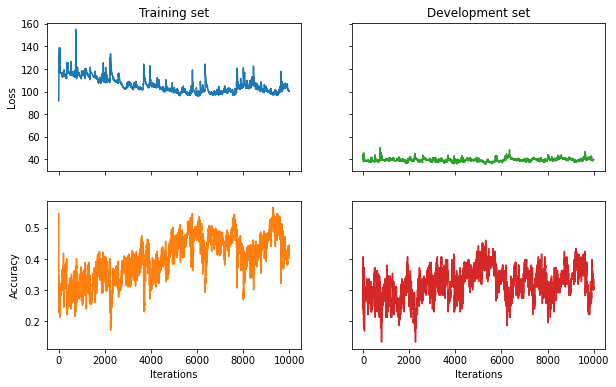

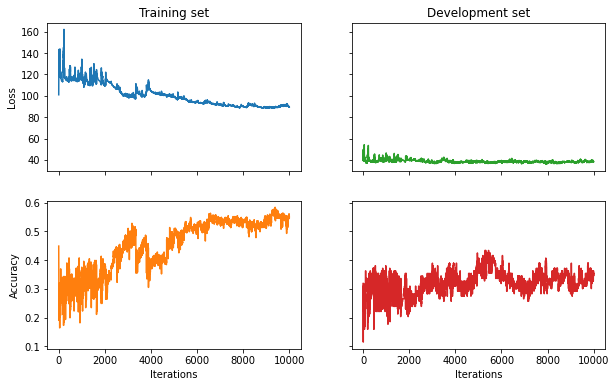

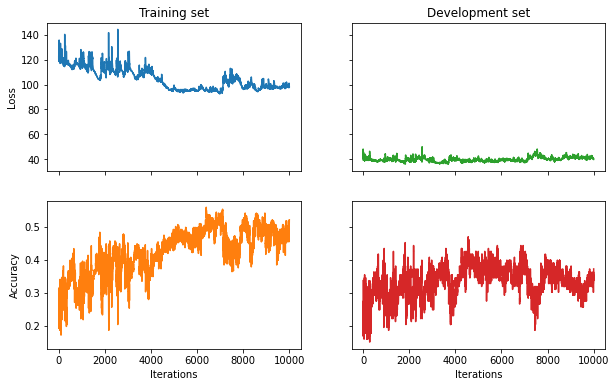

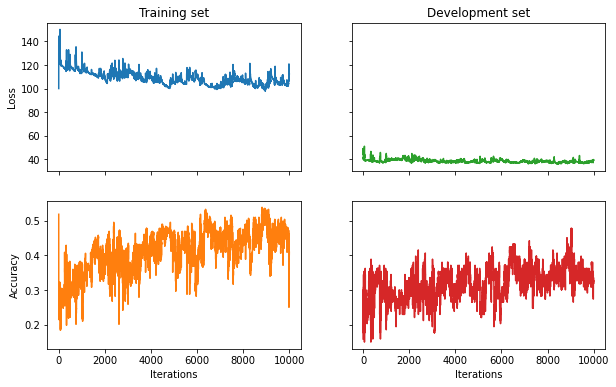

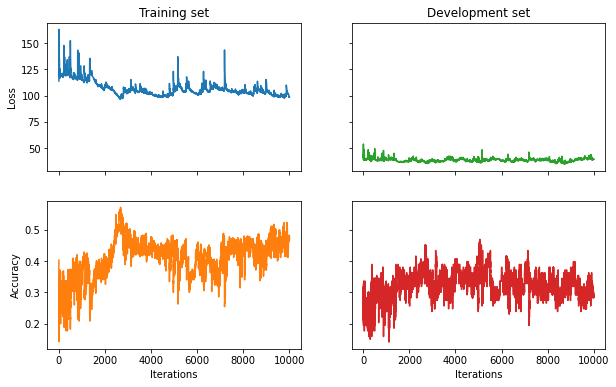

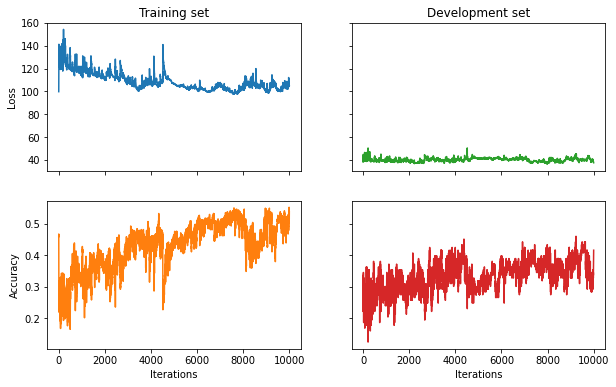

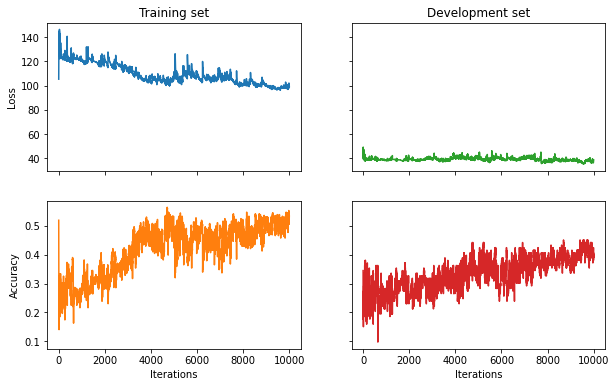

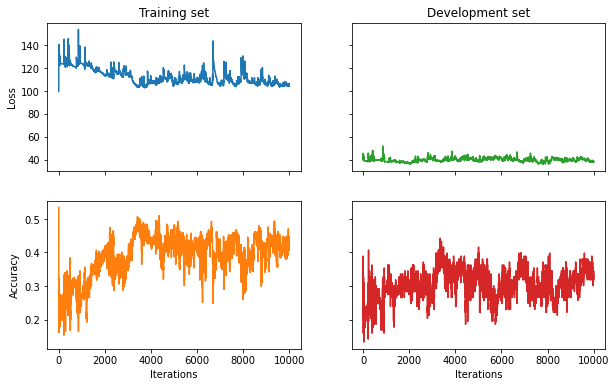

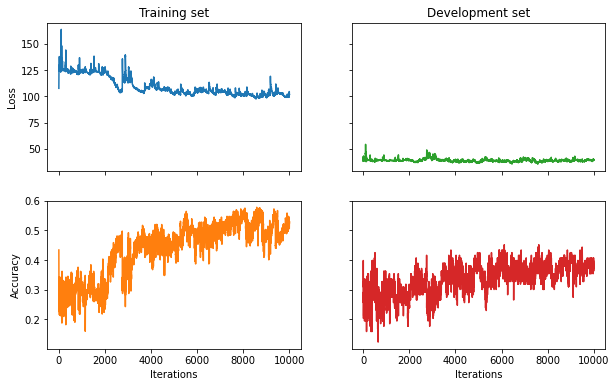

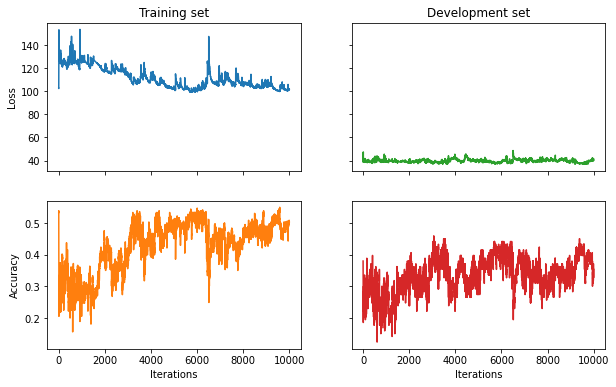

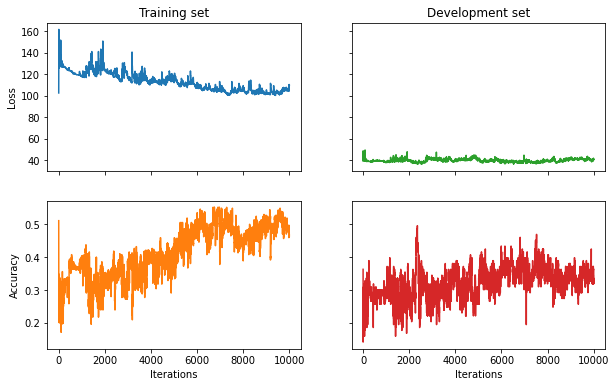

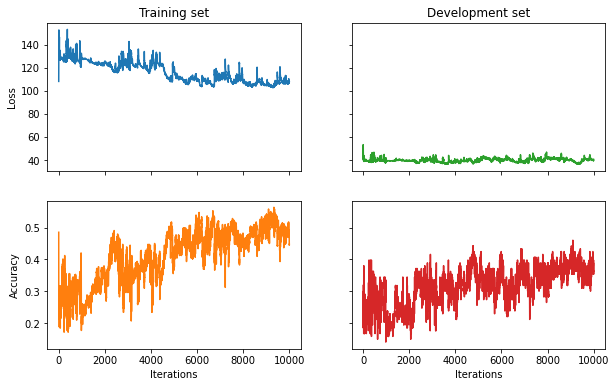

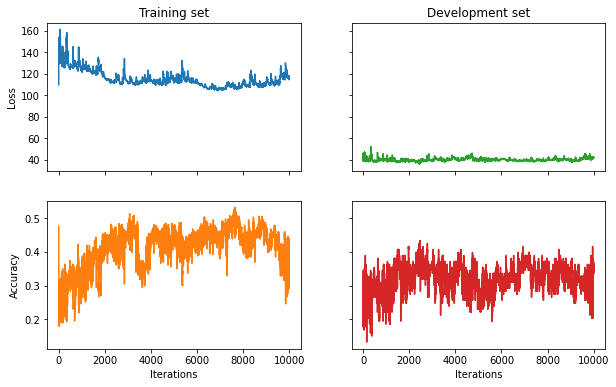

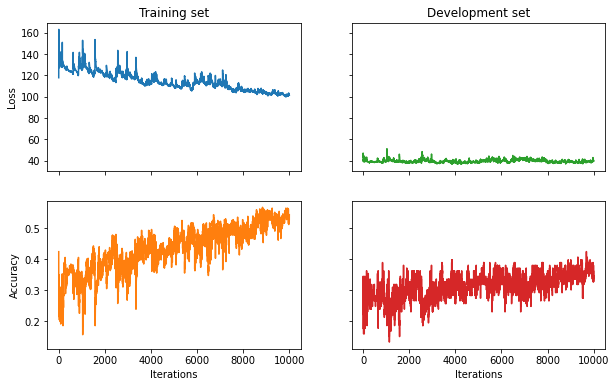

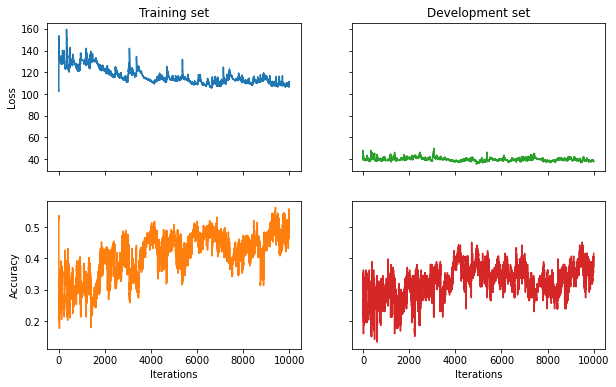

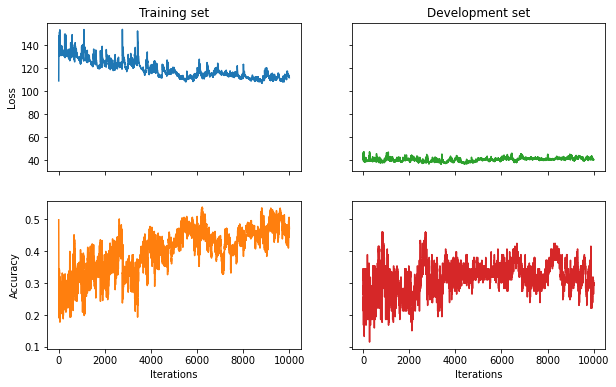

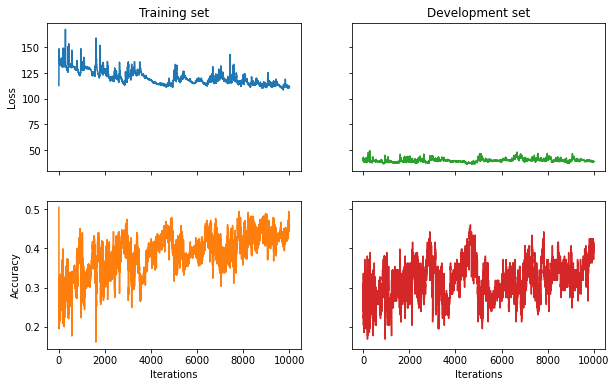

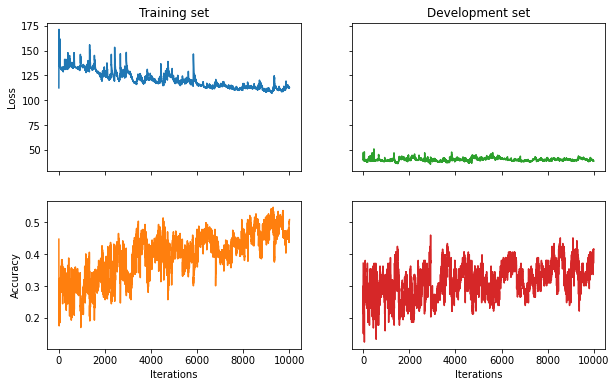

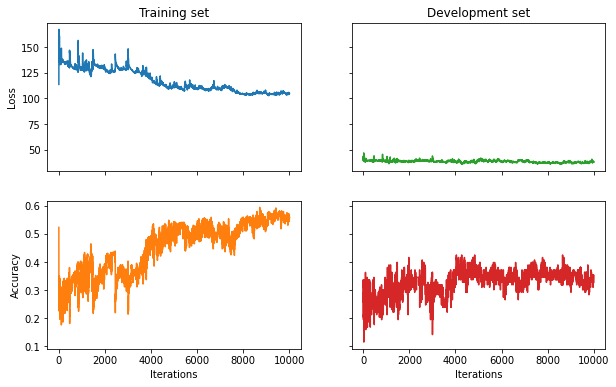

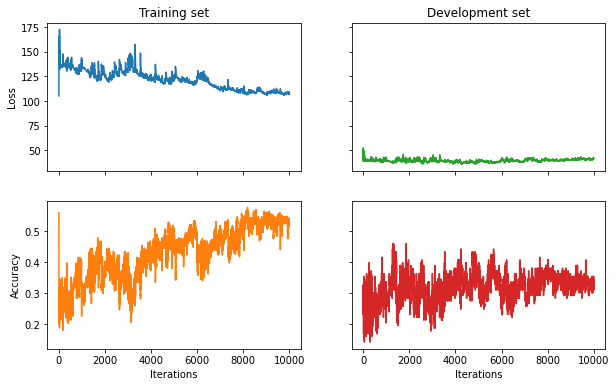

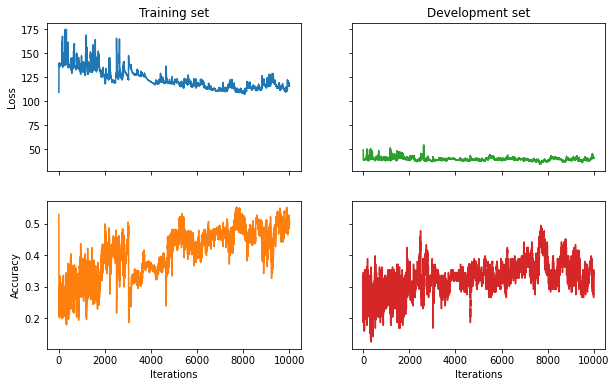

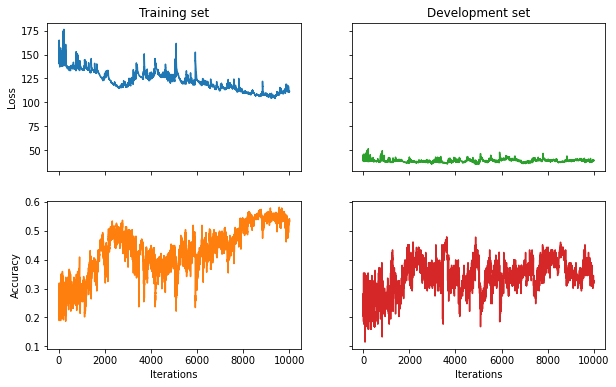

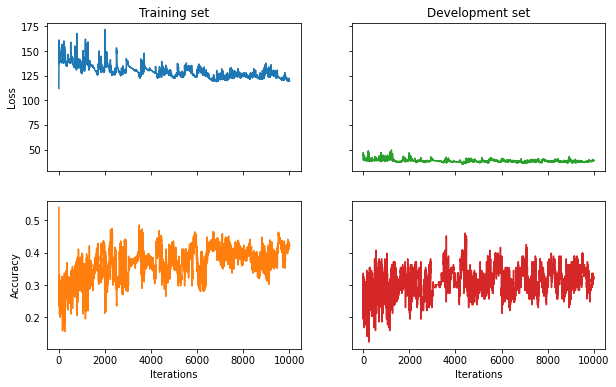

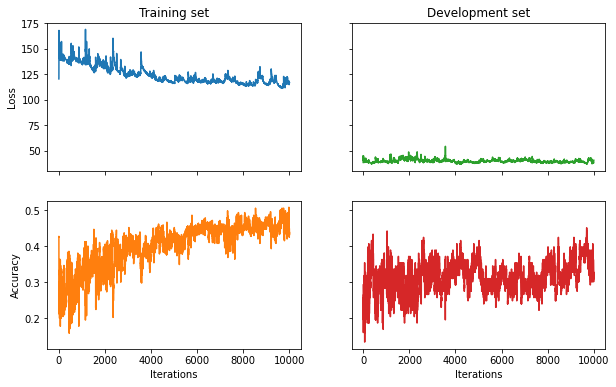

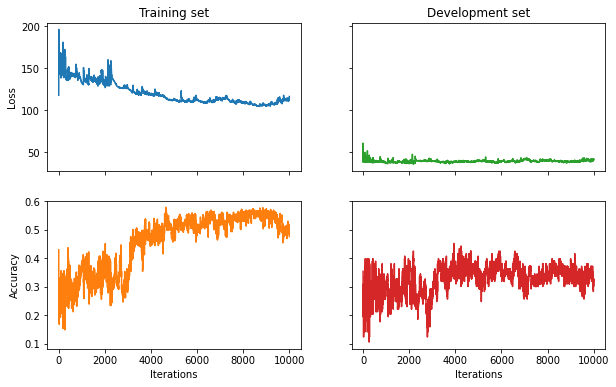

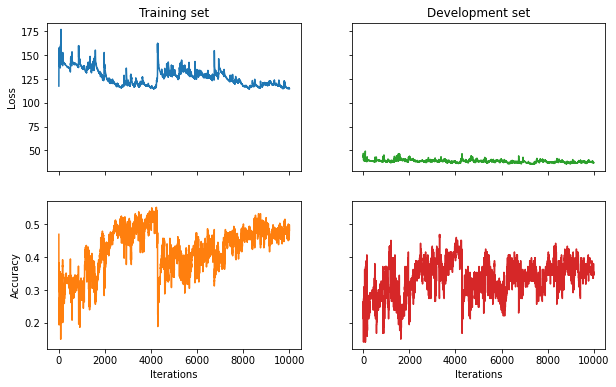

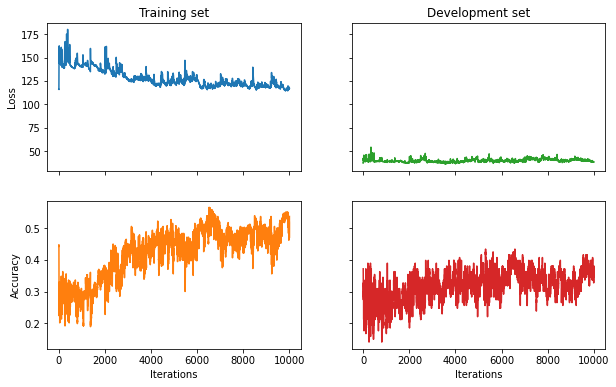

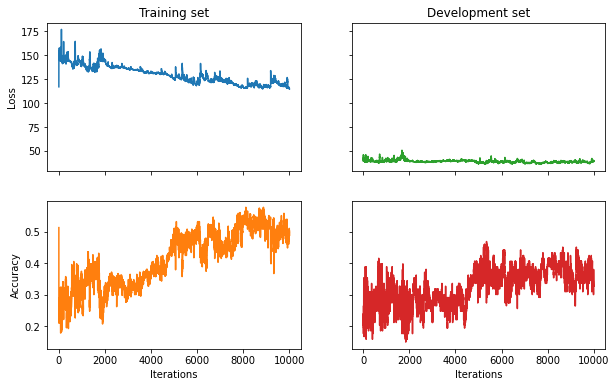

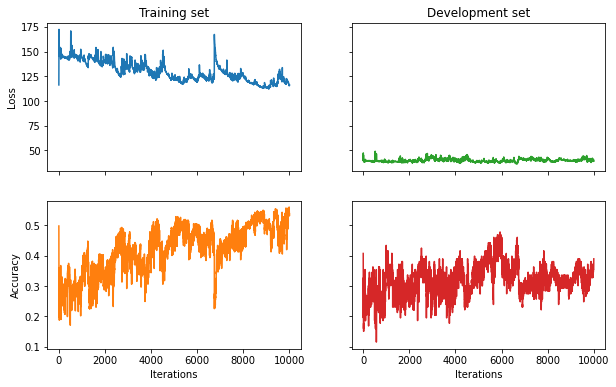

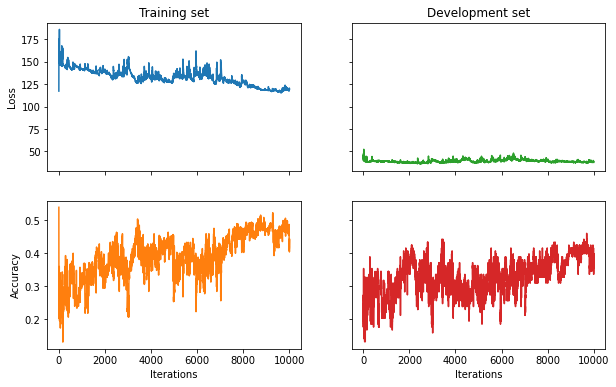

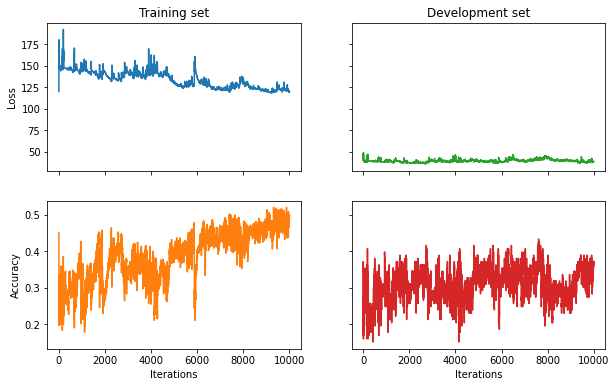

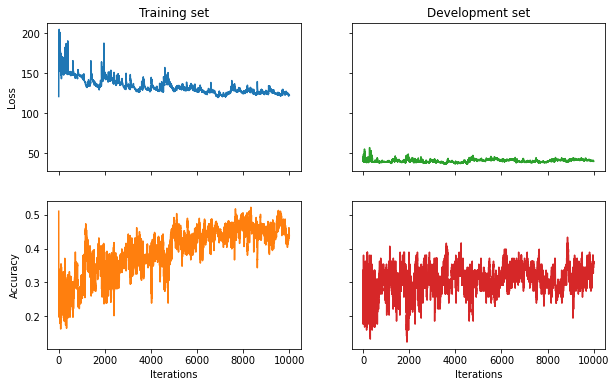

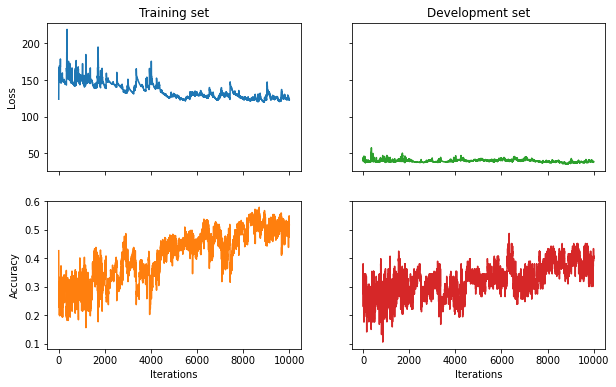

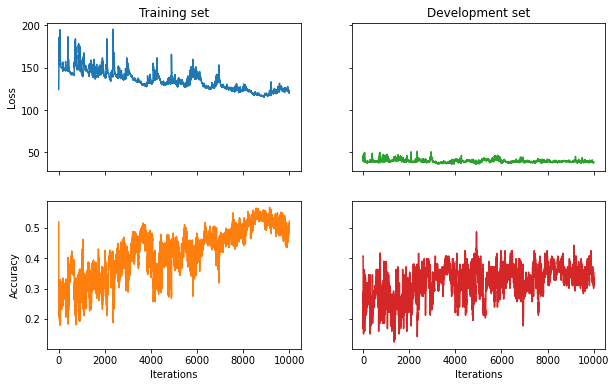

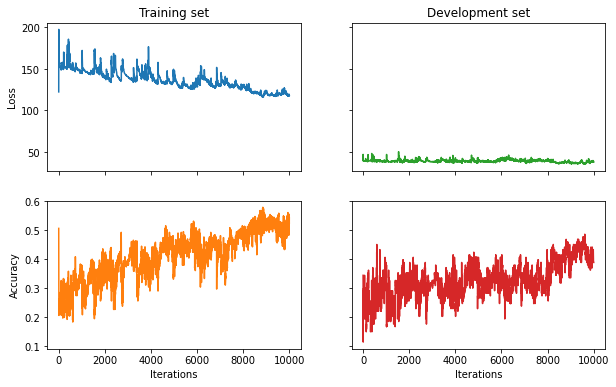

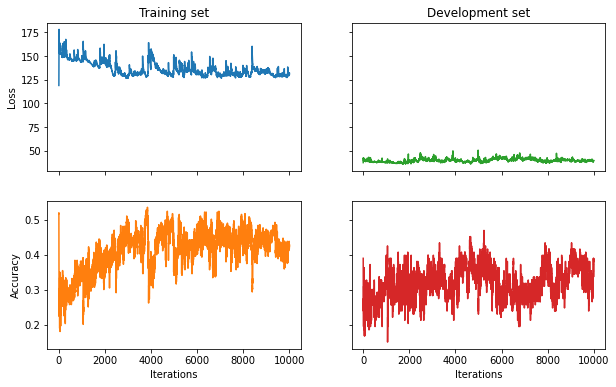

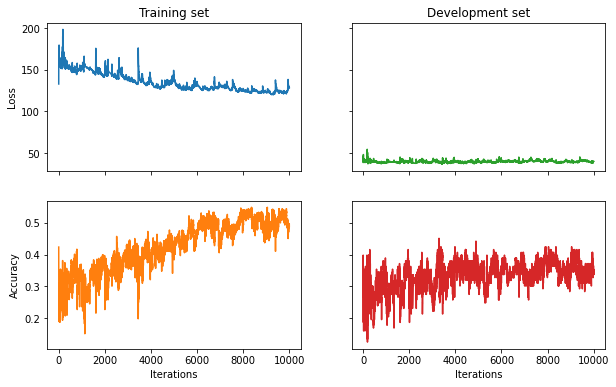

In [9]:
result = None

for i, key in enumerate(all_training_keys[initial_number_of_circuits:]):
    print("Progress: ", round((i + initial_number_of_circuits)/len(all_training_keys), 3))
    
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[1:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            if result:
                parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
                #continue
            else:
                syms = get_symbols(current_training_circuits)
                parameters = sorted(syms, key=default_sort_key)
                init_params_spsa = np.array(rng.random(len(parameters)))
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    if limit:
        val_test_circ_size = ceil(len(current_training_circuits))
        if len(current_validation_circuits) > val_test_circ_size:
            validation_circuits_l = validation_circuits_l[:val_test_circ_size]
            validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
        if len(current_test_circuits) > val_test_circ_size:
            test_circuits_l = test_circuits_l[:val_test_circ_size]
            test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    stats = f"Number of training circuits: {len(training_circuits_l)}   "\
        + f"Number of validation circuits: {len(validation_circuits_l)}   "\
        + f"Number of test circuits: {len(test_circuits_l)}   "\
        + f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}"
    
    with open("results//" + result_file + ".txt", "a") as f:
        f.write(stats + "\n")
    
    print(stats)
    
    optimization_interval = 3
    
    if result == None or run % optimization_interval == 0:
    
        train_pred_fn = jit(make_pred_fn(training_circuits_l))
        dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
        test_pred_fn = make_pred_fn(test_circuits_l)

        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

        def callback_fn(xk):
            #print(xk)
            valid_loss = dev_cost_fn(xk)
            train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
            train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
            valid_acc = numpy.around(float(dev_accs[-1]), 4)
            iters = int(len(train_accs)/2)
            if iters % 200 == 0:
                info = f"Epoch: {iters}   "\
                + f"train/loss: {train_loss}   "\
                + f"valid/loss: {numpy.around(float(valid_loss), 4)}   "\
                + f"train/acc: {train_acc}   "\
                + f"valid/acc: {valid_acc}"

                with open("results//" + result_file + ".txt", "a") as f:
                    f.write(info + "\n")

                print(info, file=sys.stderr)
            return valid_loss

        #a_value = 0.0053
        #c_value = 0.0185

        # Good
        #a_value = 0.053
        #c_value = 0.00185

        a_value = 0.0053
        c_value = 0.00185

        train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
        dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)

        result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)
        #result = minimizeCompass(train_cost_fn, x0=init_params_spsa, redfactor=2.0, deltainit=1.0, deltatol=0.001, feps=1e-15, errorcontrol=True, funcNinit=30, funcmultfactor=2.0, paired=True, alpha=0.05, callback=callback_fn)

        figure_path = this_folder + "//results//" + result_file + ".png"
        visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path, result_file)
    
    run += 1
    #EPOCHS += 100
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)